In [12]:
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np


from sqlalchemy import create_engine
from sqlalchemy import text

from matplotlib import pyplot as plt
load_dotenv()

user = os.environ.get("DB_USERNAME")
password = os.environ.get("DB_PASSWORD")
hostname = os.environ.get("DB_HOST")
database_name =  os.environ.get("DB_NAME")
port = os.environ.get("DB_PORT")
cluster = os.environ.get("DB_CLUSTER")
youtube_api_key = os.environ.get("YOUTUBE_API_KEY")

engine = create_engine(f'cockroachdb://{user}:{password}@{hostname}:{port}/{database_name}?sslmode=require&options=--cluster={cluster}')

In [13]:
conn = engine.connect()
df = pd.read_sql("""SELECT vvl.* FROM video_view_lifecycle vvl
                    JOIN video_notification_feed vnf ON vvl.video_id = vnf.video_id
                    where vnf.record_timestamp > '2022-06-27 00:00:00.00' 
                    and vnf.channel_id in ('UCq6VFHwMzcMXbuKyG7SQYIg')
                    ORDER BY vvl.video_id desc, vvl.record_timestamp asc""", 
                conn)

In [14]:
df.head(5)

,video_id,video_title,channel_id,channel_name,views,likes,favorites,comment_count,dislikes,video_duration,thumbnail_url,date_uploaded,record_timestamp
0,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99350,0,5261,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:52:10.720211
1,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99350,0,5261,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:52:10.720211
2,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99350,0,5261,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:52:10.720211
3,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99350,0,5261,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:52:10.720211
4,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99362,0,5257,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:53:19.165404


In [15]:
def calc_timedetlas(row):
    return pd.Timedelta(row["record_timestamp"] - df[df["video_id"] == row["video_id"]].iloc[0]["date_uploaded"], unit='seconds').total_seconds() / 60

def calc_percentage_deltas(row):
    return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1

df["time_delta"] = df.apply(calc_timedetlas, axis=1)
df["view_delta"] = df.groupby(['video_id'])['views'].diff().fillna(0)
df["view_percentage_delta"] = df.apply(calc_percentage_deltas, axis=1)
df = df.drop_duplicates(subset=['time_delta'])

df.head(3)

/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_10222/3742548750.py:5: RuntimeWarning: invalid value encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_10222/3742548750.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1


,video_id,video_title,channel_id,channel_name,views,likes,favorites,comment_count,dislikes,video_duration,thumbnail_url,date_uploaded,record_timestamp,time_delta,view_delta,view_percentage_delta
0,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99350,0,5261,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:52:10.720211,2662.028670,0.0,0.0
4,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99362,0,5257,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:53:19.165404,2663.169423,0.0,0.0
8,wp-WCLT8kYg,Youtuber Sued for $7.6 Million by Bungie,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,1612640,99373,0,5257,-1,PT12M52S,https://i.ytimg.com/vi/wp-WCLT8kYg/default.jpg,2022-06-28 00:30:09,2022-06-29 20:54:27.582992,2664.309717,0.0,0.0


In [16]:
# channel_ids = ['UCq6VFHwMzcMXbuKyG7SQYIg', 'UCz6XquIbM5OcfK7r3hQQCXA']
# channel_df = df[df["channel_id"].isin(channel_ids)]
# channel_df['video_id'].nunique()
# channel_df[channel_df['video_id']=='qb4jMvGdOTw']

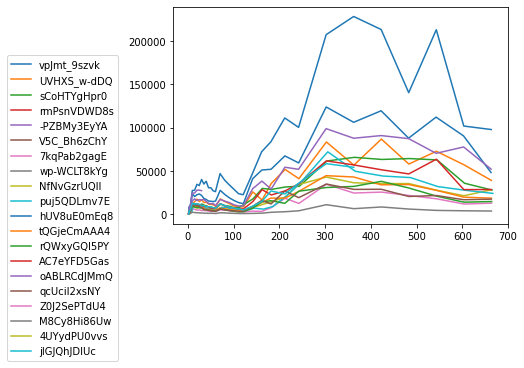

In [17]:
for video_id in set(df['video_id'].to_list()):
    video_df = df[df["video_id"] == video_id]
    video_df = video_df[video_df['time_delta'] < 60 * 12]
    video_df = video_df[video_df['view_delta'] > 0]
    plt.plot(video_df.time_delta, video_df.view_delta, label=video_id)
plt.legend(bbox_to_anchor=(-.15,.8))
plt.show()


In [42]:
def plot_video_views(df, video_ids=None, minutes=10000000, x_range=None, y_range=None):
    if not video_ids:
        video_ids = set(df['video_id'].to_list())
    for video_id in set(df['video_id'].to_list()):
        if(video_id in video_ids):
            video_df = df[df["video_id"] == video_id]
            video_df = video_df[video_df['time_delta'] < minutes]
            # video_df["logs"] = np.log(df.views)
            plt.scatter(video_df.time_delta, video_df.views, label=video_df.iloc[0]["video_title"])

    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.axvline(x=1440)
    plt.legend(bbox_to_anchor=(-.15,.8))
    plt.show()

def plot_video_slopes(df, video_ids=None, minutes=10000000):
    if not video_ids:
        video_ids = set(df['video_id'].to_list())
        
    for video_id in set(df['video_id'].to_list()):
        if(video_id in video_ids):
            video_df = df[df["video_id"] == video_id]
            video_df = video_df[video_df['time_delta'] < minutes]

            views = np.array(video_df['views'].to_list()).astype('uint16')
            times = np.array(video_df["time_delta"].to_list()).astype('uint16')

            view_deltas = np.diff(views)
            time_deltas  = np.diff(times)

            dydx = view_deltas/time_deltas

            # print(times[:-1], dydx)
            plt.plot(times[:-1], dydx)

    plt.axvline(x=1440)
    plt.legend(bbox_to_anchor=(-.15,.8))
    plt.show()

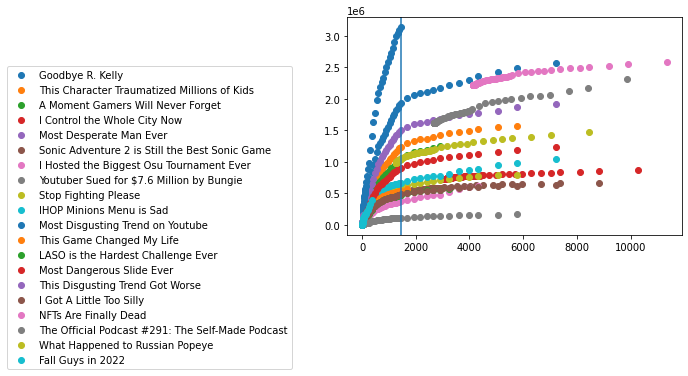

In [43]:
plot_video_views(df)

/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: divide by zero encountered in true_divide
  dydx = view_deltas/time_deltas
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: invalid value encountered in true_divide
  dydx = view_deltas/time_deltas
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: divide by zero encountered in true_divide
  dydx = view_deltas/time_deltas
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: invalid value encountered in true_divide
  dydx = view_deltas/time_deltas
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: divide by zero encountered in true_divide
  dydx = view_deltas/time_deltas
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/2007955287.py:29: RuntimeWarning: invalid value encountered in true_divid

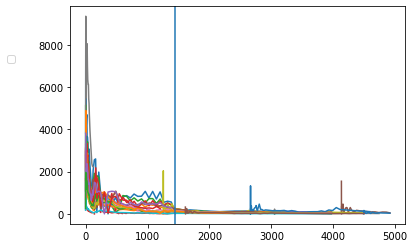

In [124]:
plot_video_slopes(df, minutes=5000)
    

[ 5.32033527e+04 -9.98726632e+00  1.07185164e+02]


/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/1652895475.py:5: RuntimeWarning: overflow encountered in power
  return a * x ** c  / (x ** c + b)
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/1652895475.py:5: RuntimeWarning: invalid value encountered in true_divide
  return a * x ** c  / (x ** c + b)
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1696/1652895475.py:5: RuntimeWarning: overflow encountered in multiply
  return a * x ** c  / (x ** c + b)


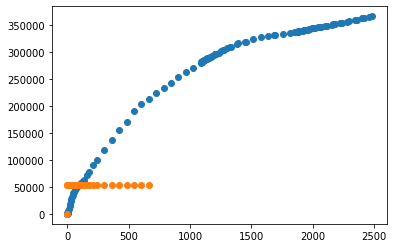

In [17]:
from scipy.optimize import curve_fit
import numpy as np

def predict(x, a, b, c):
    return a * x ** c  / (x ** c + b)

all_x_data = df.time_delta.to_list()
all_y_data = df.views.to_list()

for i in range(120, len(df.time_delta.to_list()) - 10, 5):
    x_data = all_x_data[:-100]
    y_data = all_y_data[:-100]
    
    param = None
    param_cov = None
    residuals = None
    try:
        param, param_cov = curve_fit(predict, x_data, y_data)
    except RuntimeError as e:
        print(f"Could not fit with {i} samples")
        continue

    print(param) 
    y_pred = predict(df.time_delta, *param)
    plt.scatter(video_df.time_delta, video_df.views, label=video_id)
    plt.scatter(df.time_delta, y_pred, label=video_id)
    break
    
    residuals = df.views- predict(df.time_delta, *param)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((df.views-np.mean(df.views))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R squared value of {r_squared} from fitted curve given {i} samples")

    # plt.scatter(video_df.time_delta, video_df.views, label=video_id)
    # plt.scatter(df.time_delta, y_pred, label=video_id)
    # plt.show()

